# Data Forecasting with prophet


# PROPHET PREDICTION

## TESTO

## Import Dependencies

In [33]:
!pip3 install chart_studio
!pip3 install pystan
!pip3 install fbprophet
!pip3 install glob2
!pip3 install python-dateutil

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation beca

In [34]:
import os
import itertools
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import datetime 
from datetime import timedelta
import math
import numpy as np
import scipy.stats as st
from prophet import Prophet
from influxdb_client import InfluxDBClient
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

In [35]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)


In [36]:
def convert_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)

In [37]:
#buckets = [ 'temperature', 'humidity', 'gas']
buckets = ["gas"]

In [42]:
#With this function we obtain the forecasted data

def bucket_forecast(bucket):
    global mse_array
    global forecasted_array
    global expected_array
    global forecasted
    global expected
    mse_array = []
    forecasted_array = []
    expected_array = []
    forecasted = []
    expected = []
    
    print(bucket)
    query = 'from(bucket: "'+ bucket +'")' \
                ' |> range(start:-30d)'\
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "' + bucket +'")' \

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    # Convert the results to dataframe
    df = convert_to_dataframe(result)
    print(df)
    df['ds'] = df['ds'].dt.tz_localize(None)

    #train_size 80% - test_size 20%

    train, test = train_test_split(df, test_size=0.2, shuffle=False)
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=30,
        n_changepoints=35,
        changepoint_range=1,
        changepoint_prior_scale=0.01
    ).fit(train)
    
    test_interval = int((test.iloc[-1]['ds'].timestamp() - test.iloc[0]['ds'].timestamp()) / 60)
    test_interval = test_interval + 5
    #print(test_interval)

    future = m.make_future_dataframe(periods=test_interval, freq= DateOffset(minutes=1))
    forecast = m.predict(future)

    forecast['ds'] = forecast.ds.dt.floor('min')
    test['ds'] = test.ds.dt.floor('min')
    metric = test.set_index('ds')[['y']].join(forecast.set_index('ds').yhat).reset_index()

    metric = metric.dropna()
    
    mse = mean_squared_error(metric['y'], metric['yhat'])
    mse_array.append(mse)
    
    expected_array.append(metric['y'].tolist())
    forecasted_array.append(metric['yhat'].tolist())
    forecasted = list(itertools.chain.from_iterable(forecasted_array))
    expected = list(itertools.chain.from_iterable(expected_array))

    

# evaluate_field('temp')
# print(mse_array)
# print(sum(mse_array)/len(mse_array))

In [43]:
APE = []
i = 0
for bucket in buckets:
	bucket_forecast(bucket)
	print("\n\nEvaluating " + bucket)
	plt.plot(expected, label="Real Value")
	plt.plot(forecasted, "-r", label="Forecasted Value")

	plt.legend(loc="upper left")
	plt.show()

	#Mean Square Error & Root Square Error considered more accurate 
	mse = mean_squared_error(expected, forecasted)
	print('mse')
	print(mse) #mah
	rmse = math.sqrt(mean_squared_error(expected, forecasted))
	print('Test RMSE: %.3f'%rmse)

	
	# MAE
	# The mean absolute error, or MAE, 
	# is calculated as the average of the forecast error values, 
	# where all of the forecast error values are forced to be positive.
	# These error values are in the original units of the predicted values. 
	# A mean absolute error of zero indicates no error.

	# Calculate the MAE 
	mae = mean_absolute_error(expected, forecasted)
	print('MAE: %f' % mae)


	# A confidence interval is an estimation technique used in statistical inference to constrain a pair or pairs of values, 
	# within which the desired point estimate will be found (with a certain probability).

	# A confidence interval will allow us to calculate two values around a sample mean (one upper and one lower). 
	# These values will bound an interval within which, with some probability, the population parameter will be found.


	mean = sum(forecasted) / len(forecasted) #mean
	print("Mean: ",mean)


	std = np.std(forecasted)  # standard deviation
	print("Standard Deviation: ",std)

	# create 95% confidence interval
	res = st.t.interval(alpha=0.95, df=len(forecasted)-1,
				loc=np.mean(forecasted),
				scale=st.sem(forecasted))

	print("Confidence intervals: ",res)

gas


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


                                   ds     y
0    2022-10-05 08:39:13.185752+00:00   161
1    2022-10-05 08:39:14.185450+00:00   167
2    2022-10-05 08:39:16.736226+00:00   170
3    2022-10-05 08:39:19.185081+00:00   144
4    2022-10-05 08:39:21.684881+00:00    94
...                               ...   ...
6062 2022-10-07 09:34:11.594008+00:00  1001
6063 2022-10-07 09:34:14.090820+00:00  1047
6064 2022-10-07 09:34:16.591482+00:00   919
6065 2022-10-07 09:34:19.090150+00:00   912
6066 2022-10-07 09:34:21.594715+00:00   924

[6067 rows x 2 columns]


RuntimeError: Error during optimizing, error code -6

In [ ]:
"""mse_array = []
forecasted_array = []
expected_array = []
forecasted = []
expected = []

for bucket in buckets:
    print(bucket)
    query = 'from(bucket: "'+ bucket +'")' \
                ' |> range(start:-1d)'\
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "' + bucket +'")' \

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    print(result)

    # Convert the results to dataframe
    df = result_to_dataframe(result)
    print(df)
    df['ds'] = df['ds'].dt.tz_localize(None)

    #train_size = 80% and test_size = 20%
    train, test = train_test_split(df, test_size=0.2, shuffle=False)

    m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=30,
            n_changepoints=35,
            changepoint_range=1,
            changepoint_prior_scale=0.01
        ).fit(train)

    test_interval = int((test.iloc[-1]['ds'].timestamp() - test.iloc[0]['ds'].timestamp()) / 60)
    test_interval = test_interval + 5
    print(test_interval)

    future = m.make_future_dataframe(periods=test_interval, freq= DateOffset(minutes=1))
    forecast = m.predict(future)

    forecast['ds'] = forecast.ds.dt.floor('min')
    test['ds'] = test.ds.dt.floor('min')
    metric = test.set_index('ds')[['y']].join(forecast.set_index('ds').yhat).reset_index()
    metric = metric.dropna()
    mse = mean_squared_error(metric['y'], metric['yhat'])
    mse_array.append(mse)
     

    forecasted_array.append(bucket+": "+str(metric))
    m.plot(forecast, uncertainty=True, xlabel = bucket)
    m.plot_components(forecast)
    expected_array.append(metric['y'].tolist())
    forecasted_array.append(metric['yhat'].tolist())


print(mse_array)
print(metric)
"""


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



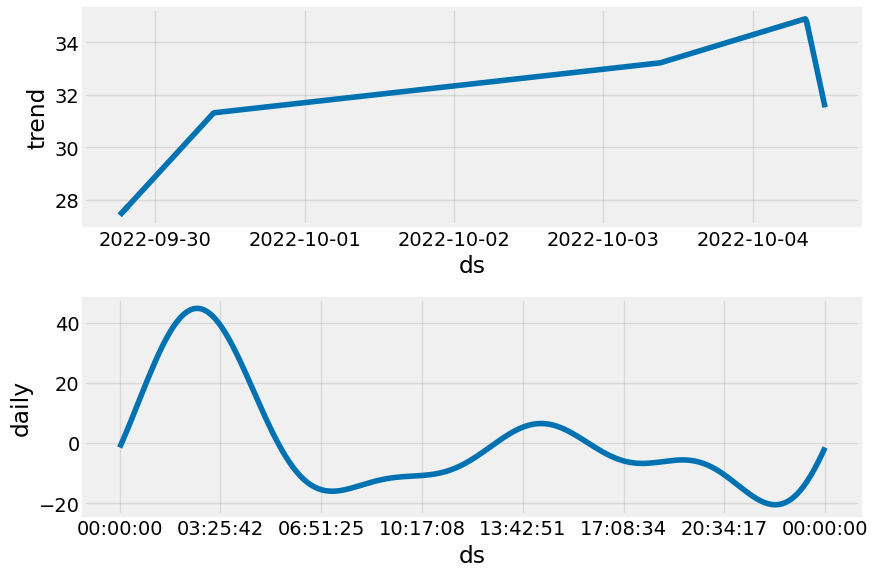

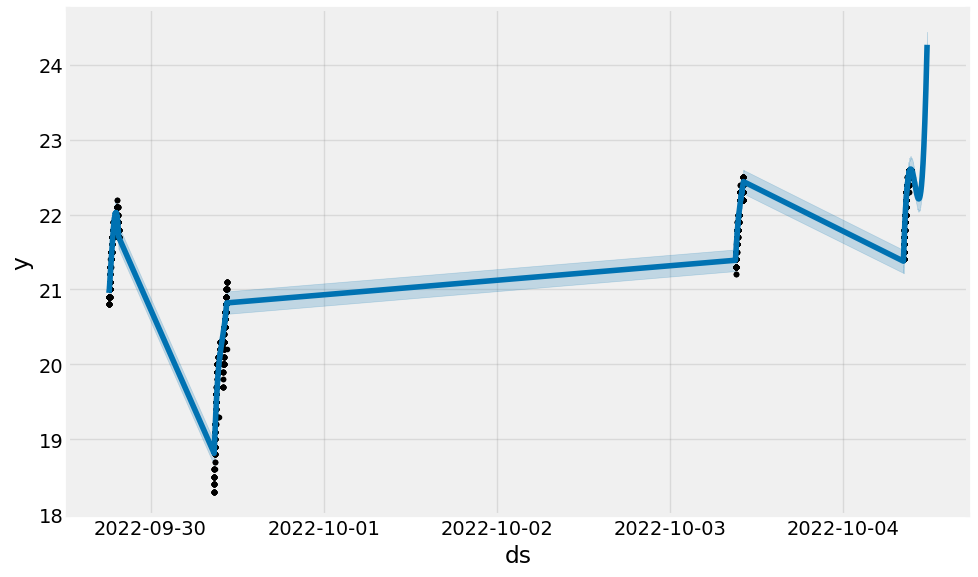

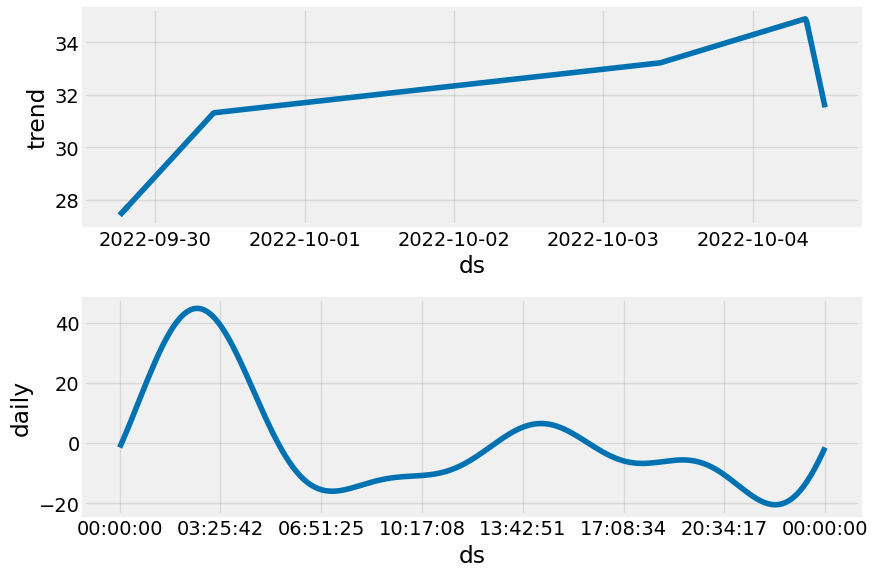

In [317]:
m.plot(forecast, uncertainty=True)

m.plot_components(forecast)
